In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from defina import *
from coordinate_transform import *
from plots import pickle_dump, pickle_load

In [2]:

ct = CoordinateTransform()
ct.solve_pde()


86355


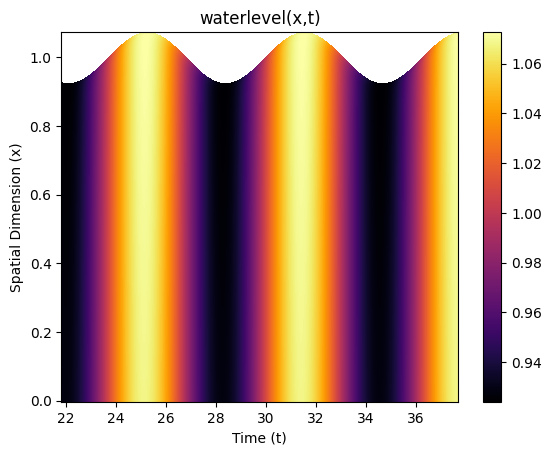

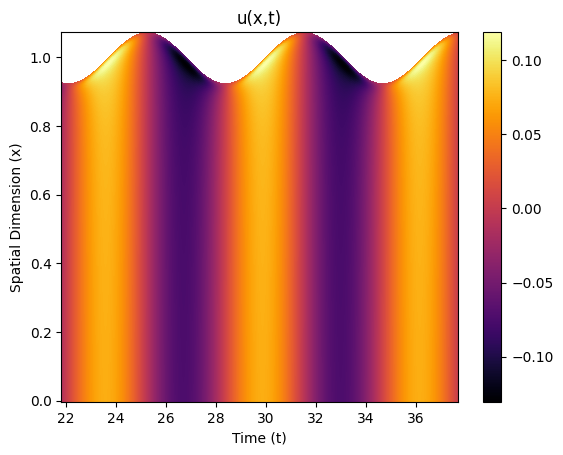

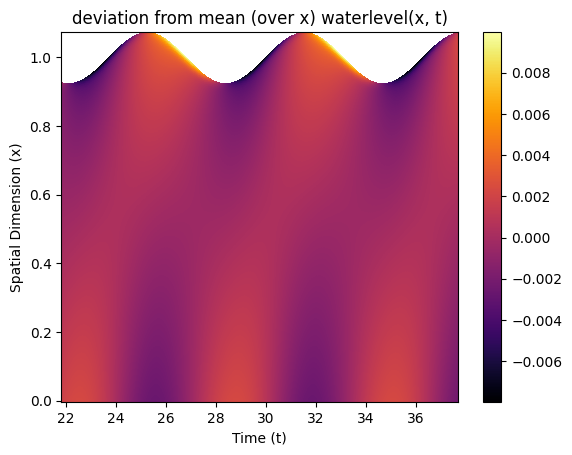

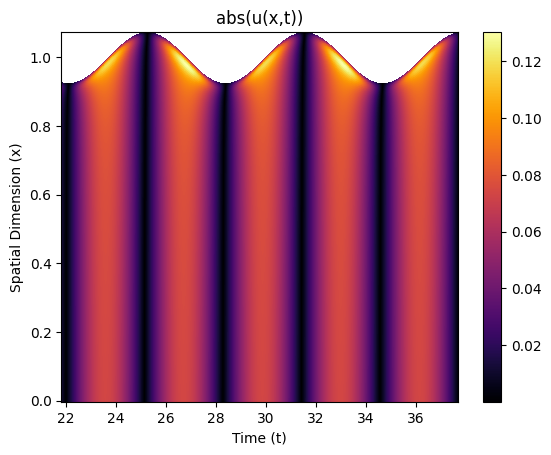

In [3]:
ct_sol = ct.generate_solution()
ct_sol.heatmaps()

Object successfully pickled to 'mysolution.pkl'


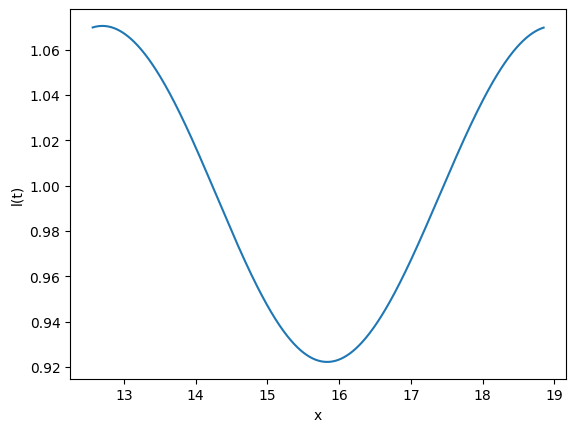

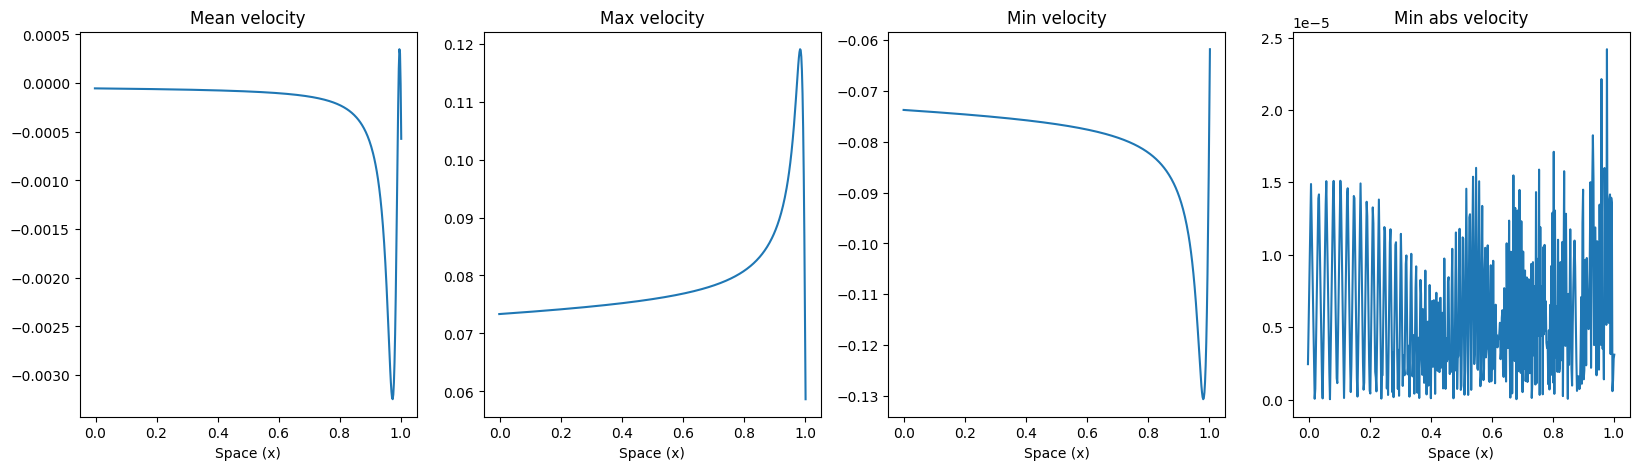

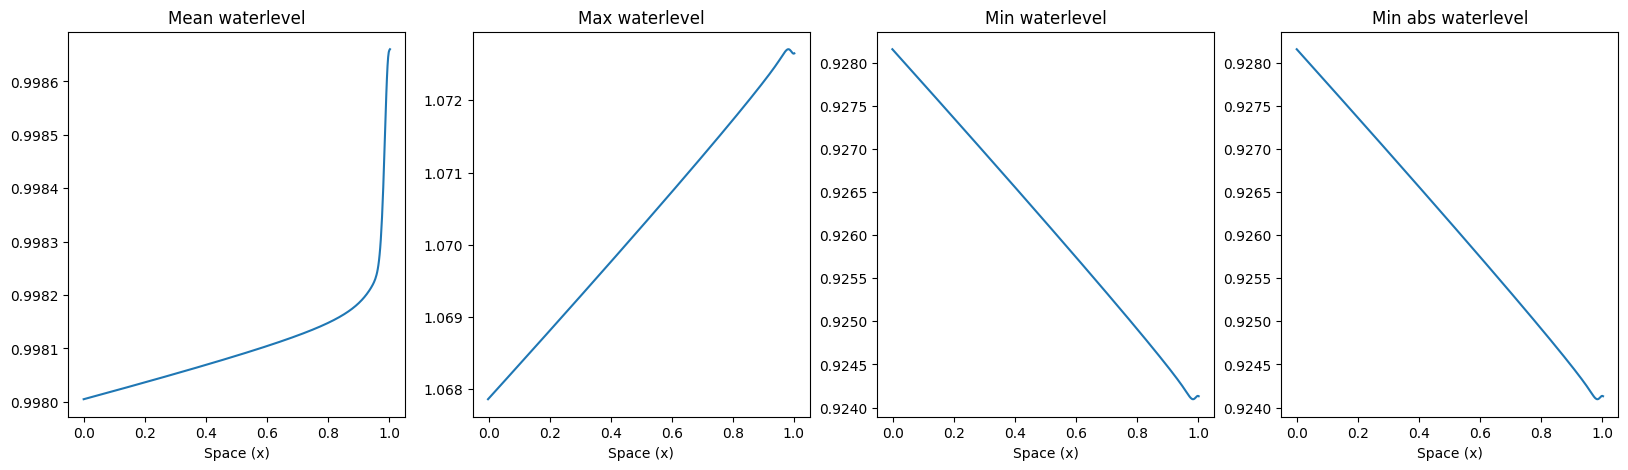

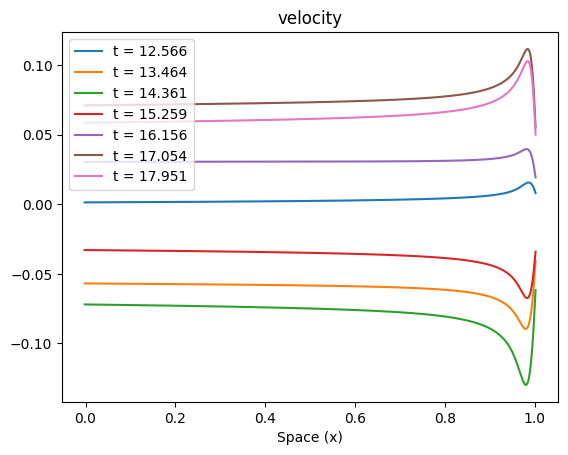

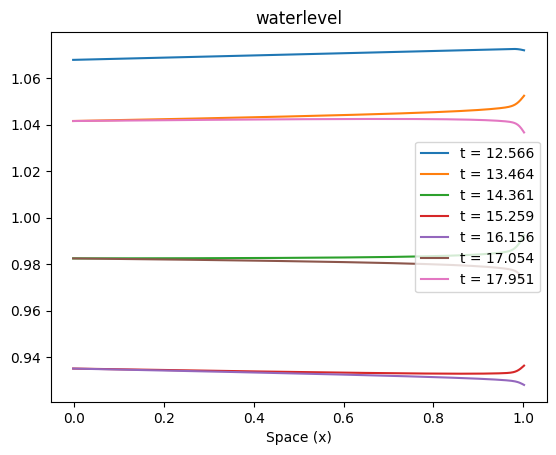

In [4]:
per_ct_sol = ct_sol.one_period_solution()

pickle_dump(per_ct_sol, "mysolution.pkl")

per_ct_sol.other_plots()

here
12929
530
[6.68851e-01 4.73101e-01 2.34158e-03 8.80270e-01 1.00000e-08 1.00000e-08 1.00000e-08 1.00000e-08 1.00000e-08 1.00000e-08]
[9.01603e-01 1.16856e-01 7.61795e-01 5.17792e-06 1.00000e+00 1.00000e-08 1.00000e-08 1.00000e-08 1.00000e-08 1.00000e-08]
[6.79358e-01 8.52425e-01 2.55392e-03 1.00000e-08 1.00000e-08 1.00000e+00 1.00000e-08 1.00000e-08 1.00000e-08 1.00000e-08]
-----
[1.95288e-03 -2.15457e-03 -2.33407e-03 -7.84615e-03 -6.70639e-03 -1.33358e-02 -1.52318e-02 -1.86184e-02 -2.07815e-02 -2.36970e-02]
[7.72058e-04 -1.19284e-04 -4.99934e-03 2.07949e-03 -1.05910e-02 -1.09684e-02 -1.59771e-02 -1.80067e-02 -2.11577e-02 -2.33535e-02]
[2.28173e-03 -2.10515e-03 1.25881e-03 -7.79516e-03 5.61479e+01 -1.32840e-02 -1.44875e-02 -1.85674e-02 -2.06801e-02 -2.36475e-02]
[8.23611e-04 1.85066e-03 -4.95002e-03 -2.12341e+04 -1.05396e-02 1.10094e+07 -1.59257e-02 -1.75838e-02 -2.11075e-02 -2.32690e-02]
-----
[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 1.00000e+00 1.0

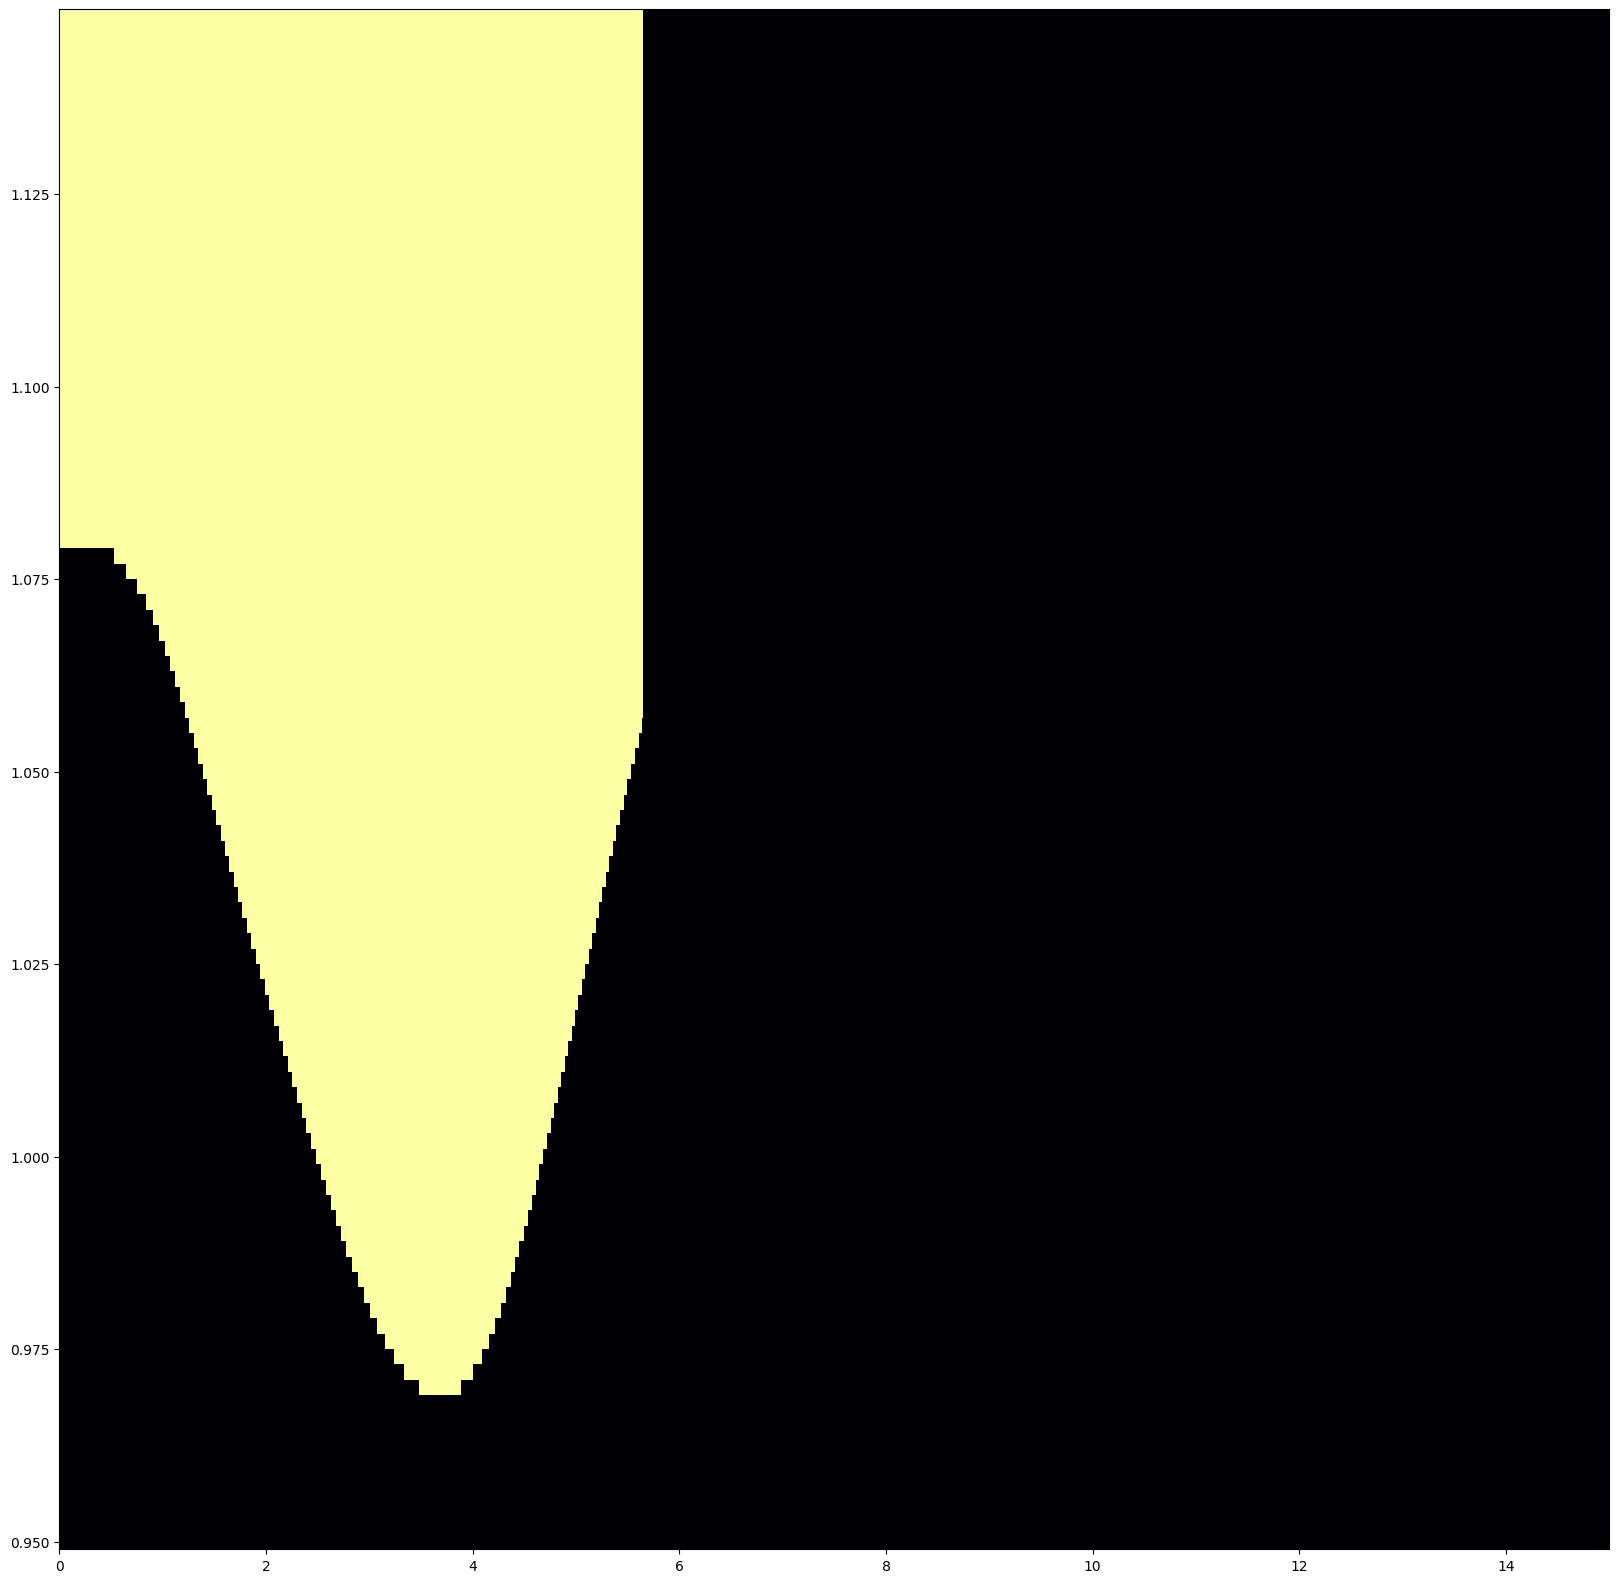

SystemError: 

In [ ]:
np.set_printoptions(threshold=40, edgeitems=4)
np.set_printoptions(linewidth=160)
np.set_printoptions(
    formatter={'float_kind': lambda x: f"{x:.5e}"}
    #formatter={'float_kind': lambda x: f"{x:.2g}"},
    #suppress=False 
)

d = Defina()
d.dL = 0.2
d.solve_pde()


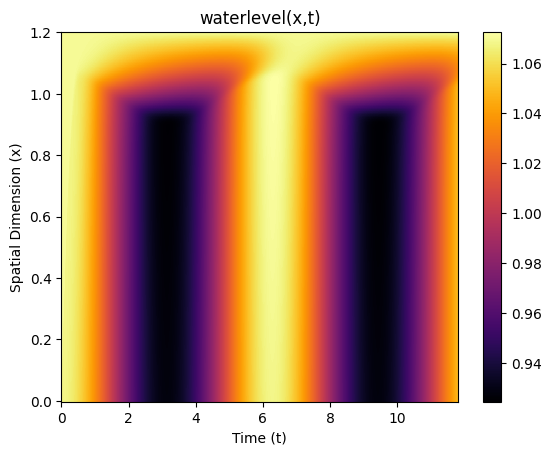

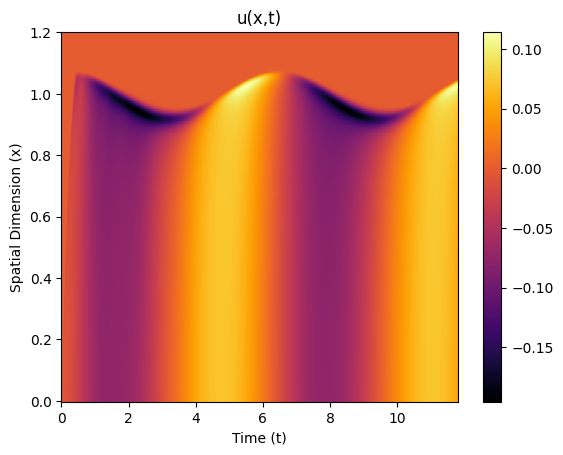

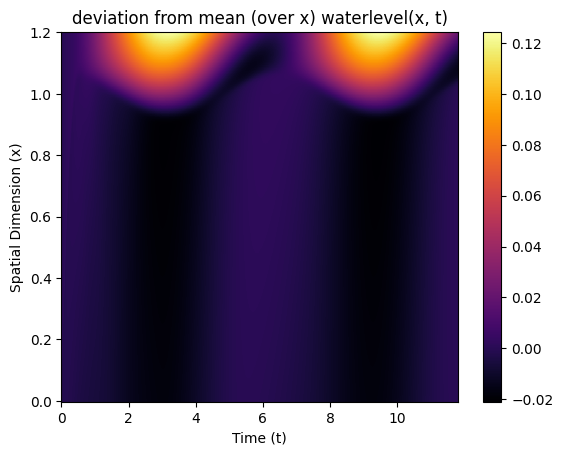

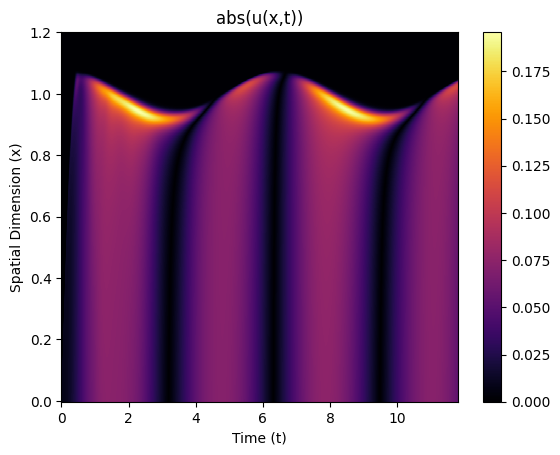

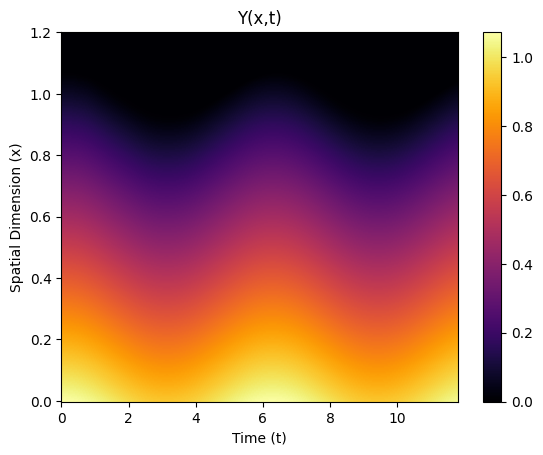

In [41]:
d_sol = d.generate_solution()
d_sol.heatmaps()


In [ ]:

per_d_sol = d_sol.one_period_solution()
per_d_sol.other_plots()